In [1]:
%reload_ext autoreload
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from scipy import stats
import statsmodels.api as sm
import scipy

# import own scripts
import sys
sys.path.insert(0, '/src/')

%autoreload 2
from utils import plot_multi, norm_dist_test, Model, clean_gdp, grid_search_SARIMA, \
test_stationarity, decompose_trend, plot_resid, one_step_ahead_forecast, dynamic_forecast, norm_pdf

In [2]:
# load data
gdp = clean_gdp(pd.read_csv('data/GDPC1.csv'))
ff = pd.read_csv('src/results/ff.csv', index_col='Date')

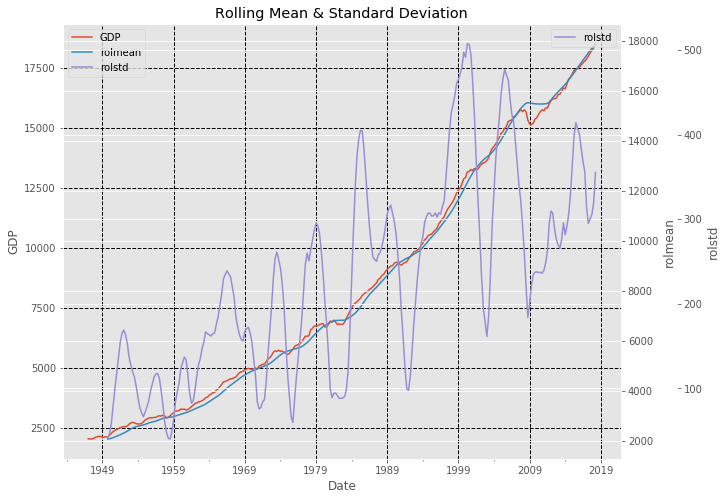

Results of Dickey-Fuller Test:
Test Statistic                   2.915394
p-value                          1.000000
#Lags Used                      12.000000
Number of Observations Used    273.000000
Critical Value (1%)             -3.454533
Critical Value (5%)             -2.872186
Critical Value (10%)            -2.572443
dtype: float64


In [3]:
test_stationarity(gdp, 'GDP',12)

Dickey–Fuller test: p=1.000000


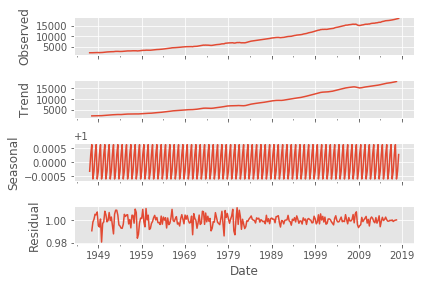

In [4]:
decompose_trend(gdp, 'GDP', model='multiplicative')

Dickey–Fuller test: p=0.781648


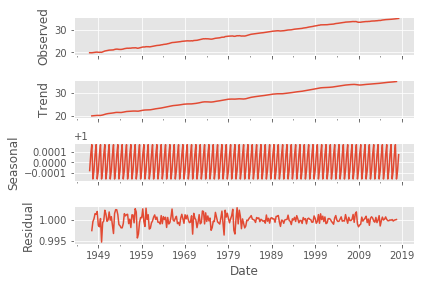

In [7]:
gdp['box_cox'], _ = stats.boxcox(gdp['GDP'])
decompose_trend(gdp, 'box_cox', model='multiplicative')

In [8]:
gdp_sarima_model = grid_search_SARIMA(gdp['GDP'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3063.651, BIC=3081.698, Fit time=0.790 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3285.895, BIC=3293.114, Fit time=0.150 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3137.762, BIC=3152.200, Fit time=0.698 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3078.007, BIC=3092.445, Fit time=0.463 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3062.194, BIC=3083.851, Fit time=1.479 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3133.434, BIC=3151.481, Fit time=1.318 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3062.454, BIC=3087.720, Fit time=6.437 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3245.692, BIC=3260.130, Fit time=0.193 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3064.441, BIC=3093.317, Fit time=9.430 seconds
Fit ARIMA: order=(0, 1, 1) s

In [10]:
gdp_sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  286
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1522.398
Date:                            Mon, 24 Sep 2018   AIC                           3060.797
Time:                                    10:55:30   BIC                           3089.673
Sample:                                         0   HQIC                          3072.388
                                            - 286                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1207      1.385      2.253      0.024       0.406       5.835
ar.L1          0.4479      0.173      2.592      0.010       0.109       0.787
ma.L1         -0.1651      0.184     -0.899      0.369      -0.525       0.195
ma.L2          0.1714      0.068      2.534      0.011       0.039       0.304
ar.S.L12      -0.7059      0.242     -2.920      0.003      -1.180      -0.232
ma.S.L12      -0.3627      0.253     -1.432      0.152      -0.859       0.134
ma.S.L24      -0.5521      0.276     -2.003      0.045      -1.092      -0.012
sigma2      3646.1503    298.915     12.198      0.000    3060.287    4232.014
===================================================================================
Ljung-Box (Q):                       48.61   Jarque-Bera (JB):               255.80
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               4.98   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
import statsmodels.api as sm


mod = sm.tsa.statespace.SARIMAX(gdp['GDP'],
                                freq=gdp.index.inferred_freq,
                                trend=gdp_sarima_model.trend, 
                                order=gdp_sarima_model.order, 
                                seasonal_order=gdp_sarima_model.seasonal_order)
results = mod.fit(maxiter=500)
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                GDP   No. Observations:                  286
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1522.367
Date:                            Mon, 24 Sep 2018   AIC                           3060.734
Time:                                    11:10:57   BIC                           3089.609
Sample:                                01-01-1947   HQIC                          3072.325
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9561      1.349      2.191      0.028       0.312       5.601
ar.L1          0.4649      0.169   

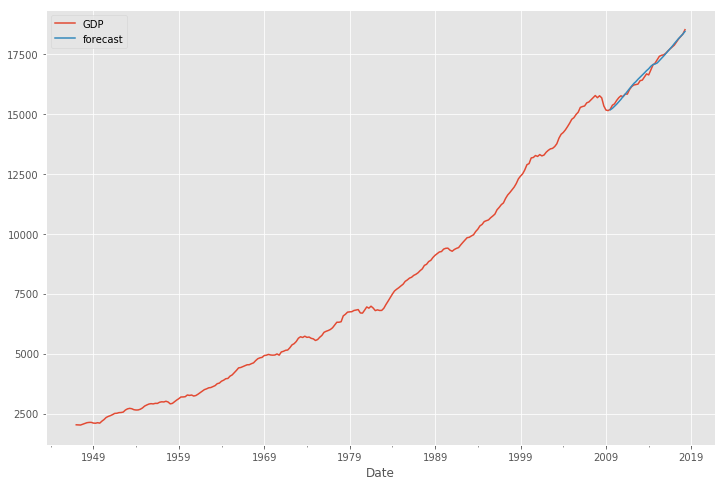

In [70]:
gdp['forecast']= results.predict(start = 250, end= 286, dynamic= True) 
gdp[['GDP', 'forecast']].plot(figsize=(12, 8))

Dickey–Fuller test: p=0.923273


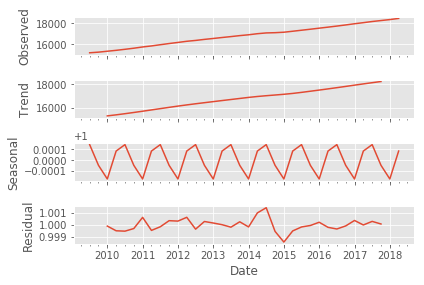

In [71]:
decompose_trend(gdp.iloc[250:], 'forecast', model='multiplicative')

Dickey–Fuller test: p=1.000000


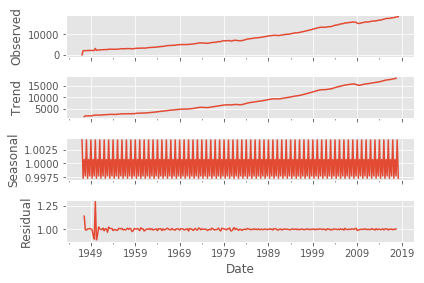

In [65]:
gdp['SARIMA'] = gdp_sarima_model.predict_in_sample()
decompose_trend(gdp, 'SARIMA', model='multiplicative')

## Rebuild ARIMA and Incorporate `FedFunds`
---
> integrate optimal `order` and `seasonal_order` parameters <br>
> integrate exog array with `FedFund` SARIMA

In [66]:
merged = gdp.join(ff).dropna(axis=0)
merged.head()

ValueError: columns overlap but no suffix specified: Index(['rolmean', 'rolstd', 'box_cox', 'SARIMA'], dtype='object')

In [331]:
exog = np.array(merged['SARIMA']).reshape(-1, 1)
gdp_sarimax_model = grid_search_SARIMA(merged['GDP'], exog=exog)

Dickey–Fuller test: p=0.999009


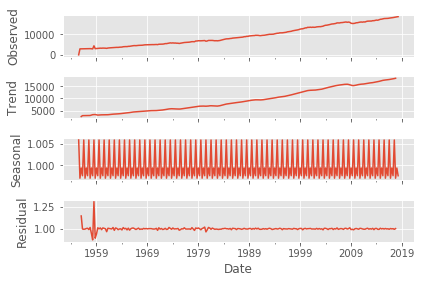

In [338]:
merged['SARIMAX'] = gdp_sarimax_model.predict_in_sample(exog)
decompose_trend(merged, 'SARIMAX', model='multiplicative')

## Grid Search for best parameters for ARIMA Model (no exogenous data)
---
> obtain optimal `order` and `seasonal_order` parameters <br>
> GDP report release time @ 8:30am

In [304]:
gdp_sarima_model = gdp_sarima_model.fit(gdp['GDP'])
gdp_sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  286
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1522.398
Date:                            Mon, 17 Sep 2018   AIC                           3060.797
Time:                                    10:06:14   BIC                           3089.673
Sample:                                         0   HQIC                          3072.388
                                            - 286                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1207      1.385      2.253      0.024       0.406       5.835
ar.L1          0.4479      0.173      2.592      0.010       0.109       0.787
ma.L1         -0.1651      0.184     -0.899      0.369      -0.525       0.195
ma.L2          0.1714      0.068      2.534      0.011       0.039       0.304
ar.S.L12      -0.7059      0.242     -2.920      0.003      -1.180      -0.232
ma.S.L12      -0.3627      0.253     -1.432      0.152      -0.859       0.134
ma.S.L24      -0.5521      0.276     -2.003      0.045      -1.092      -0.012
sigma2      3646.1503    298.915     12.198      0.000    3060.287    4232.014
===================================================================================
Ljung-Box (Q):                       48.61   Jarque-Bera (JB):               255.80
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               4.98   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [373]:
gdp.shape

(286, 1)

In [374]:
gdp_sarima_model.resid().shape

(252,)

In [365]:
# plot residual errors
plot_resid_SARIMA(gdp_sarima_model, gdp['GDP'])

ValueError: Shape of passed values is (1, 252), indices imply (1, 286)

In [341]:
gdp_sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1346.668
Date:                            Mon, 17 Sep 2018   AIC                           2705.336
Time:                                    10:33:24   BIC                           2726.195
Sample:                                         0   HQIC                          2713.741
                                            - 252                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1760      0.560      2.100      0.036       0.079       2.274
x1             8.0741      2.674      3.019      0.003       2.832      13.316
ar.L1          0.6559      0.128      5.124      0.000       0.405       0.907
ma.L1         -0.3582      0.155     -2.308      0.021      -0.662      -0.054
ma.S.L12      -0.9888      0.353     -2.802      0.005      -1.680      -0.297
sigma2      3974.7796   1353.541      2.937      0.003    1321.888    6627.671
===================================================================================
Ljung-Box (Q):                       48.92   Jarque-Bera (JB):               182.33
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

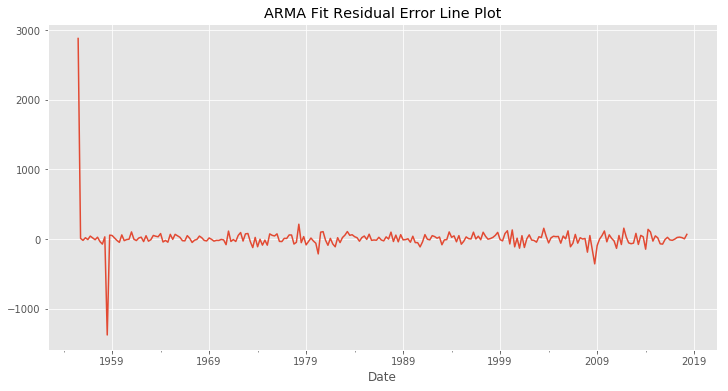

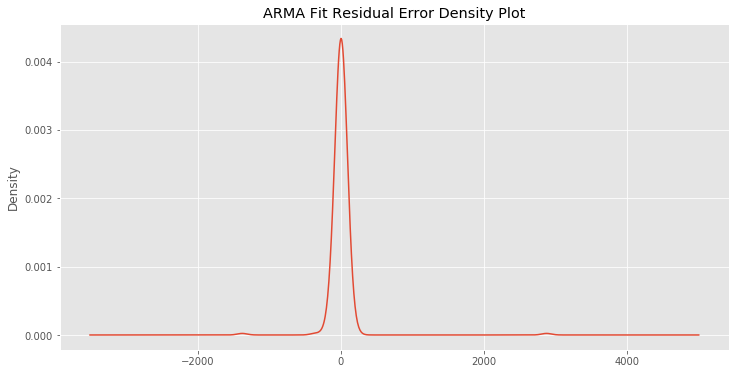

         residuals
count   252.000000
mean      7.418174
std     211.450529
min   -1377.627967
25%     -33.173175
50%       1.695207
75%      42.862902
max    2877.720576


In [343]:
plot_resid_SARIMA(gdp_sarimax_model, merged['GDP'])

In [354]:
one_step_ahead_forecast(gdp_sarimax_model.fit(merged['GDP']), merged,'2000',10)

AttributeError: 'numpy.ndarray' object has no attribute 'conf_int'

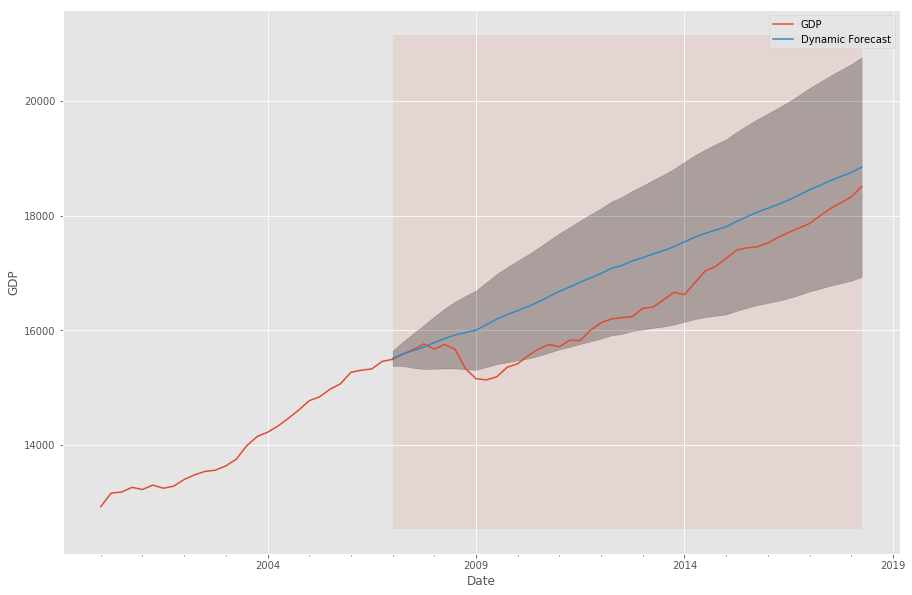

In [284]:
dynamic_forecast(model2, gdp, '2000', '2007-01-01')

In [153]:
# Change in AIC
[model1.aic(), model2.aic]

[3060.7969932677556, 2456.20552754132]

## Hypothesis Testing of Residual Errors
---
> H0: mu1 = mu2 <br>
> H1: mu1 != mu2 <br>
> alpha = .05

TypeError: unsupported operand type(s) for /: 'function' and 'int'

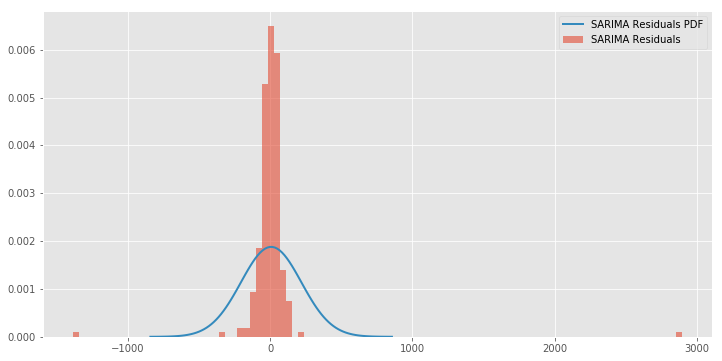

In [364]:
plt.figure(figsize=(12,6))
norm_dist_test(gdp_sarima_model.resid(), "SARIMA Residuals")
norm_dist_test(gdp_sarimax_model.resid, "SARIMAX Residuals")
plt.title("mu1 = {}, mu2 = {}".format(str(np.mean(model1.resid())),str(np.mean(model2.resid))))

In [357]:
# Use KS test to see if there is a difference
scipy.stats.ks_2samp(gdp_sarima_model.resid(), gdp_sarimax_model.resid)

AxisError: axis -1 is out of bounds for array of dimension 0

KS test p-value = .09 in the distribution of Residual Errors. Therefore, failed to reject the H0, i.e **`model_1` and `model_2` residuals are not statistically different.**

In [363]:
gdp_sarima_model.resid()

array([ 2.89438627e+03,  7.80094542e+00, -2.10188839e+01,  1.59218683e+01,
       -9.90095125e+00,  4.13865478e+01,  1.24776350e+01, -1.28535259e+01,
        2.34363314e+01, -3.64450149e+01, -8.14884364e+01,  1.88920661e+01,
       -1.38522337e+03,  6.04210986e+01,  5.63934323e+01,  1.67802553e+01,
       -2.28713701e+01, -4.97240271e+01,  6.39096194e+01, -1.61890084e+01,
       -1.97046037e+01, -6.32531719e+00,  1.06997897e+02,  1.53556706e+01,
       -3.42314779e+01,  1.23553140e+01,  3.05870465e+01, -3.18243189e+01,
        3.59304198e+01, -3.11172292e+01, -1.00917922e+01,  5.33322377e+01,
        4.20630634e+01,  3.13787521e+01,  7.93443440e+01, -3.50330421e+01,
       -2.90778334e+01, -4.57343219e+01,  6.91664063e+01, -2.46141773e+00,
        6.30256672e+01,  4.78321047e+01,  2.01166167e+01, -2.26845445e+01,
       -1.88433031e+01,  5.25515315e+01,  1.54931762e+01, -5.86904961e+01,
       -2.04725004e+01, -8.75757819e-01,  4.84060576e+01,  2.00814711e+01,
       -1.97435149e+01, -

In [262]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-.1,.1), copy=True)

In [270]:
source = np.array([3060.7969932677556, 2456.20552754132]).reshape(-1, 1)
scaler.fit_transform(source)

array([[ 0.1],
       [-0.1]])

In [ ]:
a = []